## for image

In [1]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer, AutoModel, CLIPModel
import torch
from torch import Tensor
import torch.nn.functional as F
from PIL import Image
import os
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.11.attn.bias', 'decoder.transformer.h.4.attn.bias', 'decoder.transformer.h.0.attn.masked_bias', 'decoder.transformer.h.6.crossattention.bias', 'decoder.transformer.h.5.attn.bias', 'decoder.transformer.h.2.crossattention.bias', 'decoder.transformer.h.5.attn.masked_bias', 'decoder.transformer.h.11.attn.masked_bias', 'decoder.transformer.h.0.attn.bias', 'decoder.transformer.h.7.attn.masked_bias', 'decoder.transformer.h.1.attn.bias', 'decoder.transformer.h.9.attn.masked_bias', 'decoder.transformer.h.9.attn.bias', 'decoder.transformer.h.1.crossattention.bias', 'decoder.transformer.h.3.crossattention.masked_bias', 'decoder.transformer.h.7.crossattention.bias', 'decoder.transformer.h.10.attn.masked_bias', 'decoder.transformer.h.6.crossattention.masked_bias', 'decoder.transformer.h.2.attn.masked_bias', 'decoder.transformer.h.6.attn.mask

In [3]:
def min_max_normalization(l):
    #l_min = min(l)
    #l_max = max(l)
    l_min = 1
    l_max = 5
    return [((i - l_min) / (l_max - l_min)) for i in l]

def predict_step(image_paths):
    images = []
    for image_path in image_paths:
        i_image = Image.open(image_path)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")

        images.append(i_image)

    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    output_ids = model.generate(pixel_values, **gen_kwargs)

    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds

def read_text_file(file_path):
    with open(file_path, 'r') as f:
        return f.read().strip()

def average_pool(last_hidden_states: Tensor,attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [4]:
dir_videos = "splitted/enquete/"
dir_prompts = "./アンケート/prompts/"

video_paths = [os.path.join(dir_videos, x) for x in os.listdir(dir_videos)]
prompt_paths = [os.path.join(dir_prompts, x) for x in os.listdir(dir_prompts)]

In [5]:
sequences = []

test_num = len(video_paths)
print(f"test_num:{test_num}")

for i in tqdm(range(len(video_paths))):
    video_path = video_paths[i]
    sequence = predict_step([video_path])
    sequences.append(sequence[0])

test_num:496


100%|██████████| 496/496 [19:02<00:00,  2.30s/it]


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SentenceTransformer("intfloat/multilingual-e5-base")
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-base')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-base').to(device)

In [7]:
min_outputs = []
#max_outputs = []
#mean_outputs = []

min_captions = []

for i in tqdm(range(len(prompt_paths))):
    prompt_path = prompt_paths[i]
    scores = []

    for j in range(16):
        sequence = sequences[i * 16 + j]

        sequence = 'query: ' + str(sequence)
        text = 'passage: ' + str(read_text_file(prompt_path))

        input_texts = [sequence, sequence, text, text]
        batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
        output = model(**batch_dict)
        embeddings = average_pool(output.last_hidden_state, batch_dict['attention_mask'])
        embeddings = F.normalize(embeddings, p=2, dim=1)
        output = (embeddings[:2] @ embeddings[2:].T)

        output = output[0][0]
        output = output.detach().numpy()
        scores.append(output)
    #mean_outputs.append(sum(scores) / len(scores))
    #max_outputs.append(max(scores))
    min_outputs.append(min(scores))
    min_captions.append(scores.index(min(scores)))

100%|██████████| 31/31 [00:41<00:00,  1.35s/it]


In [12]:
#print("mean")
#for i in range(len(prompt_paths)):
#    print(f"{i + 1}:")
#    for j in range(16):
#        print(sequences[i * 16 + j])
#    print(f"score:{mean_outputs[i]}")
#print("max")
#for i in range(len(prompt_paths)):
#    print(f"{i + 1}:")
#    for j in range(16):
#        print(sequences[i * 16 + j])
#    print(f"score:{max_outputs[i]}")
#print("min")
#for i in range(len(prompt_paths)):
#    print(f"{i + 1}:")
#    for j in range(16):
#        print(sequences[i * 16 + j])
#    print(f"score:{min_outputs[i]}")

for i in range(31):
    print(f"{i+1}:{sequences[i*16+min_captions[i]]}:{min_outputs[i]}")

print("comparing finished.")

csv = pd.read_csv("./Ground_Truth.csv")
ground_score = []

for i in range(len(prompt_paths)):
    index = 'q' + str(3 * i + 2)
    ground_score.append(csv[index].mean())
    print(f"{i+1}:{csv[index].mean()}")

ground_score = min_max_normalization(ground_score)

print("Final average score")
#print(f"mean: {sum(mean_outputs)/len(mean_outputs)}, Total videos: {len(mean_outputs)}")
#S_scores = pd.Series(mean_outputs)
#S_ground_score = pd.Series(ground_score)
#print(f"Spearman's : {S_scores.corr(S_ground_score, method='spearman')}")
#print(f"Kendall's : {S_scores.corr(S_ground_score, method='kendall')}")
#print(f"Spearman's : {S_ground_score.corr(S_scores, method='spearman')}")
#print(f"Kendall's : {S_ground_score.corr(S_scores, method='kendall')}")

#print(f"max: {sum(max_outputs)/len(max_outputs)}, Total videos: {len(max_outputs)}")
#S_scores = pd.Series(max_outputs)
#S_ground_score = pd.Series(ground_score)
#print(f"Spearman's : {S_scores.corr(S_ground_score, method='spearman')}")
#print(f"Kendall's : {S_scores.corr(S_ground_score, method='kendall')}")
#print(f"Spearman's : {S_ground_score.corr(S_scores, method='spearman')}")
#print(f"Kendall's : {S_ground_score.corr(S_scores, method='kendall')}")

print(f"min: {sum(min_outputs)/len(min_outputs)}, Total videos: {len(min_outputs)}")
S_scores = pd.Series(min_outputs)
S_ground_score = pd.Series(ground_score)
print(f"Spearman's : {S_scores.corr(S_ground_score, method='spearman')}")
print(f"Kendall's : {S_scores.corr(S_ground_score, method='kendall')}")
print(f"Spearman's : {S_ground_score.corr(S_scores, method='spearman')}")
print(f"Kendall's : {S_ground_score.corr(S_scores, method='kendall')}")

1:a woman wearing a clown mask and holding a cell phone:0.7296301126480103
2:a horse statue on the side of a road:0.7225256562232971
3:a red and white water fountain with a red and white clock on it:0.7212255597114563
4:a woman with red hair and red eyes:0.7754348516464233
5:a herd of sheep standing on top of a dirt field:0.7721688747406006
6:three swans are swimming in the water near a body of water:0.8653014898300171
7:a statue of a man and a horse on a beach:0.7565993666648865
8:a beautiful young woman in a pink dress posing for a picture:0.7355852127075195
9:a table topped with plates of cake and flowers:0.7873200178146362
10:a train on a train track near a bridge:0.8416134119033813
11:a man in a black and white photo:0.7619758248329163
12:a woman sitting on a bench next to a painting:0.7826555967330933
13:a woman standing on a sidewalk holding a tennis racquet:0.8046223521232605
14:a woman sitting on the grass with an umbrella:0.7642844915390015
15:a blue and white bird sitting on

In [ ]:
plt.scatter(ground_score, mean_outputs)
plt.plot(ground_score, np.poly1d(np.polyfit(ground_score, mean_outputs, 1))(ground_score))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [ ]:
plt.scatter(ground_score, max_outputs)
plt.plot(ground_score, np.poly1d(np.polyfit(ground_score, max_outputs, 1))(ground_score))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

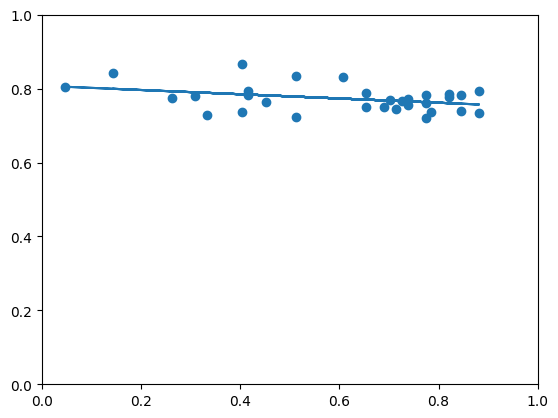

In [9]:
plt.scatter(ground_score, min_outputs)
plt.plot(ground_score, np.poly1d(np.polyfit(ground_score, min_outputs, 1))(ground_score))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## for video

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

In [ ]:
dir_videos = "./アンケート/videos/"
video_paths = [os.path.join(dir_videos, x) for x in os.listdir(dir_videos)]

In [ ]:
sequences = []

test_num = len(video_paths)
print(f"test_num:{test_num}")

for i in tqdm(range(len(video_paths))):
    video_path = video_paths[i]
    sequence = predict_step([video_path])
    sequences.append(sequence[0])

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

In [ ]:
outputs = []

for i in tqdm(range(len(video_paths))):
    prompt_path = prompt_paths[i]
    sequence = sequences[i]

    sequence = 'query: ' + str(sequence)
    text = 'passage: ' + str(read_text_file(prompt_path))

    input_texts = [sequence, sequence, text, text]
    batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
    output = model(**batch_dict)
    embeddings = average_pool(output.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    scores = (embeddings[:2] @ embeddings[2:].T)
    output = scores[0][0]
    output = output.detach().numpy()
    outputs.append(output)

for i in range(len(prompt_paths)):
    print(f"{i + 1}:{sequences[i]}, score:{outputs[i]}")

In [ ]:
print(f"mean: {sum(outputs)/len(outputs)}, Total videos: {len(outputs)}")
S_scores = pd.Series(outputs)
S_ground_score = pd.Series(ground_score)
print(f"Spearman's : {S_scores.corr(S_ground_score, method='spearman')}")
print(f"Kendall's : {S_scores.corr(S_ground_score, method='kendall')}")

In [ ]:
plt.scatter(ground_score, outputs)
plt.plot(ground_score, np.poly1d(np.polyfit(ground_score, outputs, 1))(ground_score))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [ ]:
def calculate_clip_score(video_path, text, model, tokenizer):
    # Load the video
    cap = cv2.VideoCapture(video_path)

    # Extract frames from the video
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized_frame = cv2.resize(frame,(224,224))  # Resize the frame to match the expected input size
        frames.append(resized_frame)

    # Convert numpy arrays to tensors, change dtype to float, and resize frames
    tensor_frames = [torch.from_numpy(frame).permute(2, 0, 1).float() for frame in frames]

    # Initialize an empty tensor to store the concatenated features
    concatenated_features = torch.tensor([], device=device)

    # Generate embeddings for each frame and concatenate the features
    with torch.no_grad():
        for frame in tensor_frames:
            frame_input = frame.unsqueeze(0).to(device)  # Add batch dimension and move the frame to the device
            frame_features = model.get_image_features(frame_input)
            concatenated_features = torch.cat((concatenated_features, frame_features), dim=0)

    # Tokenize the text
    text_tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=77)

    # Convert the tokenized text to a tensor and move it to the device
    text_input = text_tokens["input_ids"].to(device)

    # Generate text embeddings
    with torch.no_grad():
        text_features = model.get_text_features(text_input)

    # Calculate the cosine similarity scores
    concatenated_features = concatenated_features / concatenated_features.norm(p=2, dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
    clip_score_frames = concatenated_features @ text_features.T

    # Calculate the average CLIP score across all frames, reflects temporal consistency
    clip_score_frames_avg = clip_score_frames.mean().item()

    return clip_score_frames_avg

In [ ]:
dir_videos = "./アンケート/videos/"
dir_prompts =  "./アンケート/prompts/"

video_paths = [os.path.join(dir_videos, x) for x in os.listdir(dir_videos)]
prompt_paths = [os.path.join(dir_prompts, os.path.splitext(os.path.basename(x))[0]+'.txt') for x in video_paths]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained("./EvalCrafter/Evalcrafter/checkpoints/clip-vit-base-patch32").to(device)
clip_tokenizer = AutoTokenizer.from_pretrained("./EvalCrafter/Evalcrafter/checkpoints/clip-vit-base-patch32")

In [ ]:
CLIPscores = []

test_num = len(video_paths)
for i in tqdm(range(len(video_paths))):
    count = 0
    video_path = video_paths[i]
    prompt_path = prompt_paths[i]
    text = read_text_file(prompt_path)
    score = calculate_clip_score(video_path, text, clip_model, clip_tokenizer)
        # logging.info(f"Vid: {os.path.basename(video_path)}, Pro: {os.path.basename(prompt_path)}, Current clip_score: {score}, Current max clip_score: {m_score}")

    CLIPscores.append(score)
average_score = sum(CLIPscores) / len(CLIPscores)

In [ ]:
for i in range(len(video_paths)):
    print(f"{i+1}, Clip Score:{CLIPscores[i]}, ground = {ground_score[i]}")

print(f"Final average clip_score: {average_score}, Total videos: {len(CLIPscores)}")

In [ ]:
CLIPSeries = pd.Series(CLIPscores)

print(f"Spearman's : {CLIPSeries.corr(S_ground_score, method='spearman')}")
print(f"Kendall's : {CLIPSeries.corr(S_ground_score, method='kendall')}")

In [ ]:
plt.scatter(CLIPSeries, S_ground_score)
plt.plot(CLIPSeries, np.poly1d(np.polyfit(CLIPSeries, S_ground_score, 1))(CLIPSeries))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [ ]:
S_scores = pd.Series(outputs)

print(f"Spearman's : {S_scores.corr(CLIPSeries, method='spearman')}")
print(f"Kendall's : {S_scores.corr(CLIPSeries, method='kendall')}")

In [ ]:
plt.scatter(S_scores, CLIPSeries)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()